# Redes


In [101]:
import numpy as np
import matplotlib.pyplot as plt
import random
import bisect

# Definición de funciones importantes para el desarrollo de las redes

In [102]:
# Función que toma una cantidad de elementos N, de los cuales selecciona una fracción de ellos y les asigna un indice

# Es decir, si tengo 20 nodos y quiero seleccionar 5 de ellos al azar, esta función selecciona 5 nodos al azar y les asigna un indice de 0 a 19

def selec_sin_repeticion(N, num):
    return random.sample(range(N), num)

In [103]:
print(selec_sin_repeticion(20, 3))

[1, 19, 10]


In [104]:

def selec_sin_repeticion_lista(lista, num):
    return random.sample(lista, num)

In [105]:
lista = [0,1,2,3,4,5,6,7,8,9,10]

print(selec_sin_repeticion_lista(lista, 10))

[1, 0, 9, 5, 2, 10, 3, 4, 7, 8]


# Creación de la clase Nodo

In [106]:
class Nodo():
    def __init__(self,i):
        self.indice = i
        self.conexiones = []
        self.estado = 0
    
    def hacer_conexion(self, nodo):
        self.conexiones.append(nodo.indice)

    # Regresa el indice del i esimo nodo conectado
    def getConexion(self, i):
        return self.conexiones[i]
    
    def getNumConex(self): 
        return len(self.conexiones)

    def setEstado(self, s):
        self.estado = s

    def getEstado(self):
        return int(self.estado)
    
    def __repr__(self):
        return str(self.indice)

# Clase que forma una red de Erdos Renyi

In [188]:

class redER():
    def __init__(self,N,Z):
        M = int(N*Z/2)
        self.nd = []

        for i in range(N):
            self.nd.append(Nodo(i))
        
        conexiones_existentes = set()  # Para almacenar pares únicos de conexiones

        for _ in range(M):
            sigue = True  # Esto se asegura que en una iteración nodo1 y nodo2 no sean el mismo nodo, sin embargo, antes no se aseguraba que en una proxima iteración el nodo1 fuera el mismo que en la iteración anterior
            
            while sigue:
                nodo1 = np.random.randint(0, N)
                nodo2 = np.random.randint(0, N)

                
                if nodo1 != nodo2 and (nodo1, nodo2) not in conexiones_existentes and (nodo2, nodo1) not in conexiones_existentes:
                    sigue = False

            
            conexiones_existentes.add((nodo1, nodo2))

            self.nd[nodo1].hacer_conexion(self.nd[nodo2])
            self.nd[nodo2].hacer_conexion(self.nd[nodo1])
    
    def getNumNodos(self):
        return len(self.nd)
    
    def plotPK(self):
        N = len(self.nd)
        a = []
        b = [0] * N

        p = []
        

        for i in range(N):
            k = self.nd[i].getNumConex()
            b[k] += 1


        for i in range(N):
            if b[i] != 0:
                a.append(i)
                p.append(b[i])

    

        x = np.array(a)
        y = np.array(p)

        plt.plot(x, y, 'bo')


    def archivo(self):
        f = open("red.tgf", "w")
        for i in range(self.getNumNodos()): 
            k = self.nd[i].getNumConex()  
        
            for j in range(k): 
                conexion = self.nd[i].conexiones[j]  # Esto genera una instancia de la clase Nodo, que no se interpreta como entero
                #conexion_id = conexion.indice  #Parecido a conexion, al final obtenenemos que nodo es al que se esta conectando
                #print(f"{i} {conexion_id}")  
                if i < conexion:
                    f.write(f"{i} {conexion}\n")
        f.close()
    
    def getPrev(self):
        x = 0
        N = len(self.nd)
        for i in range(N):
            if self.nd[i].getEstado() == 1:
                x += 1

        prev = (1.0*x)/(1.0*N)
        return prev
    
    def modeloSIS(self, pi, pis, pr,fi,fv,T,graph = False):
        N = len(self.nd)
        nv = int(N*fv)
        ni = int(N*fi)

        vac = selec_sin_repeticion(N, nv)

        for i in range(nv):
            j = vac[i]
            self.nd[j].setEstado(3)

        no_vac = []
        for i in range(N):
            s = self.nd[i].getEstado()
            if s != 3:
                no_vac.append(i)

        ni = min(ni, len(no_vac))
        
        infectados = selec_sin_repeticion_lista(no_vac, ni)

        for i in range(0,len(infectados)):
            j = infectados[i]
            self.nd[j].setEstado(1)
        
        xl = [0]*T
        yl = [0]*T
        psi = 0
        for t in range(T):
            xl[t] = t
            yl[t] = self.getPrev()
            st= [0]*N

            for i in range(N):
                st[i] = self.nd[i].getEstado()
            
            for i in range(N):
                if self.nd[i].getEstado() == 0:
                    ki = self.nd[i].getNumConex()

                    for j in range(ki):
                        ji = self.nd[i].getConexion(j)

                        vecino = self.nd[ji]
                        
                        if vecino.getEstado() == 1:
                            if np.random.rand() < pi:
                                st[i] = 1
                            break

                elif self.nd[i].getEstado() == 2:
                    ki = self.nd[i].getNumConex()

                    for j in range(ki):
                        ji = self.nd[i].getConexion(j)

                        vecino = self.nd[ji]
                        
                        if vecino.getEstado() == 1:
                            if np.random.rand() < pis:
                                st[i] = 1
                            break

                else:
                    if self.nd[i].getEstado() == 1:
                        if np.random.rand() < pr:
                            st[i] = 2
            
            for i in range(N):
                self.nd[i].setEstado(st[i])
            
            if t >= (T/2):
                psi += self.getPrev()
        
        if graph:
            plt.plot(xl, yl)
            plt.show()
        
        psi = psi/(T/2)
        return psi

    def modeloSIS_phase(self,pi,pis,pr,fi,T):
        xl = []
        yl = []
        fv = 0

        while fv < 1:
            prev = self.modeloSIS(pi,pis,pr,fi,fv,T)
            xl.append(fv)
            yl.append(prev)
            fv += 0.2

        plt.figure()
        plt.plot(xl,yl)
        plt.title("Cambio de fase respecto al número de nodos vacunados al azar")
        plt.xlabel("Fraccion de vacunados")
        plt.ylabel("Prevalencia")
        plt.savefig("cambio_fase_aleatorio.pdf")
     

# Uso de una red Erdos Renyi para simular un modelo SIS y observar el cambio de fase al aumentar el porcentaje de población vacunada

Nodo0 ..... [966, 834, 952, 643, 286, 110]
Nodo1 ..... [785, 569]
Nodo2 ..... []
Nodo3 ..... [368, 818, 703]
Nodo4 ..... [497, 167, 74, 865]
Nodo5 ..... [884, 265, 412, 560, 758, 453, 742, 600]
Nodo6 ..... [290, 709, 206]
Nodo7 ..... [515, 24, 990, 650, 858, 918]
Nodo8 ..... [88, 878, 235, 508]
Nodo9 ..... [693, 315]
Nodo10 ..... [54, 405, 319]
Nodo11 ..... [402, 659, 80, 765, 379, 548]
Nodo12 ..... [36, 359, 674, 776, 841, 898, 783, 658, 156]
Nodo13 ..... [971, 815, 303, 534, 453, 389, 955]
Nodo14 ..... [315, 860, 244, 518]
Nodo15 ..... [949, 180, 160, 299, 339, 202]
Nodo16 ..... [471, 797, 358, 414, 839]
Nodo17 ..... [165, 661, 669, 223]
Nodo18 ..... [507, 986, 498, 638, 185, 526]
Nodo19 ..... [481, 945, 950, 76]


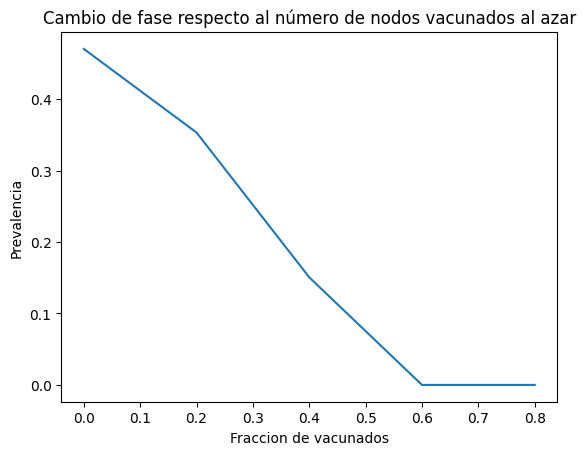

In [ ]:
red1 = redER(1000,5)
#red1.plotPK()
red1.archivo()
#red1.modeloSIS(0.1,0.1,0.1,0.1,0.8,T = 1000,graph= True)
red1.modeloSIS_phase(0.3,0.1,0.1,0.1,T = 1000)
for i in range(20):
    print(f"Nodo{i} ..... {red1.nd[i].conexiones}")


In [ ]:

f = open("red.tgf", "w")

for i in range(red1.getNumNodos()): 
    k = red1.nd[i].getNumConex()  

    for j in range(k): 
        conexion = red1.nd[i].conexiones[j]  # Esto genera una instancia de la clase Nodo, que no se interpreta como entero
        conexion_id = conexion.indice  #Parecido a conexion, al final obtenenemos que nodo es al que se esta conectando

        print(f"{i} {conexion_id}")  
        if i < conexion_id:
            f.write(f"{i} {conexion_id}\n")

f.close()


0 25
0 4
0 15
0 19
0 32
0 45
0 10
0 23
0 6
1 42
1 14
1 45
1 23
1 27
1 38
2 7
2 35
2 26
2 22
2 47
2 40
2 27
2 5
3 13
3 38
3 11
3 17
3 15
3 40
3 23
4 40
4 42
4 0
4 17
4 19
4 34
4 13
4 6
4 18
4 32
5 38
5 19
5 11
5 10
5 6
5 13
5 25
5 43
5 26
5 23
5 16
5 2
5 39
5 31
6 19
6 5
6 15
6 4
6 24
6 0
6 20
6 14
7 2
7 45
7 18
7 8
7 28
7 33
7 35
7 21
7 37
8 39
8 40
8 28
8 12
8 7
8 38
8 32
8 31
8 24
8 37
8 47
9 32
9 42
9 11
9 35
9 22
9 26
9 39
10 34
10 13
10 5
10 16
10 12
10 0
10 45
10 38
11 12
11 3
11 9
11 43
11 25
11 5
11 16
11 26
11 45
11 28
11 37
11 23
11 34
11 13
11 21
12 13
12 22
12 11
12 8
12 10
12 15
12 14
12 23
12 18
12 20
13 12
13 3
13 44
13 30
13 35
13 23
13 10
13 38
13 4
13 47
13 5
13 24
13 11
13 19
14 1
14 31
14 44
14 35
14 32
14 12
14 38
14 19
14 6
15 0
15 38
15 35
15 3
15 6
15 24
15 12
16 48
16 28
16 17
16 20
16 29
16 11
16 10
16 36
16 49
16 5
16 31
16 40
17 4
17 31
17 16
17 3
17 47
17 32
17 43
17 29
18 37
18 7
18 24
18 4
18 32
18 12
18 22
19 38
19 0
19 49
19 5
19 4
19 6
19 28
19 27
19 2

# Creación de la clase Red de enlace preferencial

In [196]:
class redBAR():
    def __init__(self,N):
        self.nd = []

        for i in range(N):
            self.nd.append(Nodo(i))

        self.nd[0].hacer_conexion(self.nd[1])
        self.nd[1].hacer_conexion(self.nd[0])


        for i in range(2,N):
            c = 0
            for j in range(0,i):
                c += self.nd[j].getNumConex()
            F = np.zeros(i + 1 , dtype= float)

            F[0] = 0
            for k in range(1,i):
                F[k] = F[k-1] + ((1.0 * self.nd[k-1].getNumConex())/c)
            
            x = random.random()
            j = bisect.bisect_left(F,x)

            self.nd[i].hacer_conexion(self.nd[j])
            self.nd[j].hacer_conexion(self.nd[i])

            
    def getNumNodos(self):
        return len(self.nd)
    
    def archivoBAR(self):
        f = open("redBarabasi.tgf", "w")
        for i in range(self.getNumNodos()): 
            k = self.nd[i].getNumConex()  
        
            for j in range(k): 
                conexion = self.nd[i].conexiones[j]  # Esto genera una instancia de la clase Nodo, que no se interpreta como entero
                #conexion_id = conexion.indice  #Parecido a conexion, al final obtenenemos que nodo es al que se esta conectando
                #print(f"{i} {conexion_id}")  
                if i < conexion:
                    f.write(f"{i} {conexion}\n")
        f.close()

    def getPrev(self):
        x = 0
        N = len(self.nd)
        for i in range(N):
            if self.nd[i].getEstado() == 1:
                x += 1

        prev = (1.0*x)/(1.0*N)
        return prev
    
    # Vamos ahora hacer el modelo SIS pero considerando una red de barabasi, enlace preferencial, con hubs de la red

    def modeloSIS(self, pi, pis, pr,fi,fv,T,graph = False):
        N = len(self.nd)
        nv = int(N*fv)
        ni = int(N*fi)

        # Sabemos que nv es el número de nodos a vacunar, ese mismo número van a ser tomado de los nodos con mayor numero de conexiones, que son los hubs de la red
    
        conexiones_lista = []
        for i in range(N):
            conexiones_lista.append((i, self.nd[i].getNumConex()))  # Guardamos el numero de conexiones y el indice del nodo

    
        conexiones_lista.sort(key=lambda x: x[1], reverse=True)  # Se hace un ordenamiento por numero de conexiones de mayor a menor

        # Como debemos vacunar solo a nv nodos, entonces, escogemos que sean los de mayor conexiones
       
        vac = []
        for i in range(nv):
            vac.append(conexiones_lista[i][0])  # Solo consideramos el indice del nodo

        
        for j in vac: # Esos indices los utilizamos para buscar en la lista de nodos y vacunarlos
            self.nd[j].setEstado(3)

        no_vac = []
        for i in range(N):
            s = self.nd[i].getEstado()
            if s != 3:
                no_vac.append(i)

        ni = min(ni, len(no_vac))
        
        # Esta parte del codigo la dejamos igual que en el caso de la red de Erdos-Renyi, ya que la elección de los nodos infectados no depende de las conexiones de los nodos
        
        infectados = selec_sin_repeticion_lista(no_vac, ni)

        for i in range(0,len(infectados)):
            j = infectados[i]
            self.nd[j].setEstado(1)
        
        xl = [0]*T
        yl = [0]*T
        psi = 0
        for t in range(T):
            xl[t] = t
            yl[t] = self.getPrev()
            st= [0]*N

            for i in range(N):
                st[i] = self.nd[i].getEstado()
            
            for i in range(N):
                if self.nd[i].getEstado() == 0:
                    ki = self.nd[i].getNumConex()

                    for j in range(ki):
                        ji = self.nd[i].getConexion(j)

                        vecino = self.nd[ji]
                        
                        if vecino.getEstado() == 1:
                            if np.random.rand() < pi:
                                st[i] = 1
                            break

                elif self.nd[i].getEstado() == 2:
                    ki = self.nd[i].getNumConex()

                    for j in range(ki):
                        ji = self.nd[i].getConexion(j)

                        vecino = self.nd[ji]
                        
                        if vecino.getEstado() == 1:
                            if np.random.rand() < pis:
                                st[i] = 1
                            break

                else:
                    if self.nd[i].getEstado() == 1:
                        if np.random.rand() < pr:
                            st[i] = 2
            
            for i in range(N):
                self.nd[i].setEstado(st[i])
            
            if t >= (T/2):
                psi += self.getPrev()
        
        if graph:
            plt.plot(xl, yl)
            plt.show()
        
        psi = psi/(T/2)
        return psi
    
    def modeloSIS_phase(self,pi,pis,pr,fi,T):
        xl = []
        yl = []
        fv = 0

        while fv < 1:
            prev = self.modeloSIS(pi,pis,pr,fi,fv,T)
            xl.append(fv)
            yl.append(prev)
            fv += 0.2

        plt.figure()
        plt.plot(xl,yl)
        plt.title("Cambio de fase al vacunar a los hubs de la red") 
        plt.xlabel("Fraccion de vacunados")
        plt.ylabel("Prevalencia")
        plt.savefig("fase_hubs.pdf")
    

    def plotPK(self):
        N = len(self.nd)
        a = []
        b = [0] * N

        p = []
        

        for i in range(N):
            k = self.nd[i].getNumConex()
            b[k] += 1


        for i in range(N):
            if b[i] != 0:
                a.append(i)
                p.append(b[i])

    

        x = np.array(a)
        y = np.array(p)

        plt.figure()
        plt.plot(x, y, 'bo')
        #plt.semilogx()
        #plt.semilogy()
        plt.title(r"Distribución P(k) de la red de Barabasi-Albert")
        plt.xlabel("Número de conexiones (k)")
        plt.ylabel("P(k)")
        plt.show()
    
        
        
        

        


        

In [197]:
red2 = redBAR(1000)


# Uso de una red de enlace preferencial para simular un modelo SIS y observar el cambio de fase al vacunar a los hubs de la red


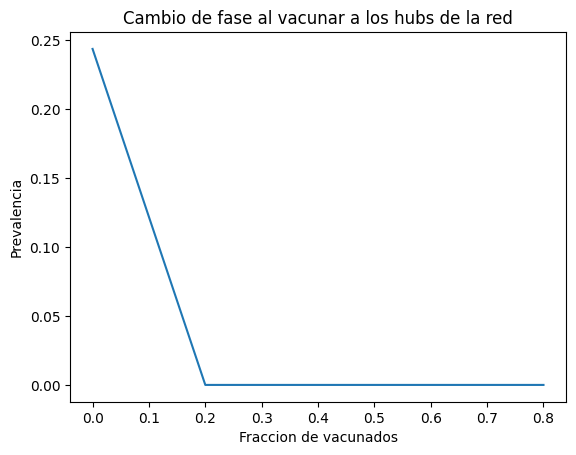

In [198]:
#red2.archivoBAR()
#red2.modeloSIS(0.3,0.1,0.1,0.1,0.1,T = 1000,graph= True)
red2.modeloSIS_phase(0.3,0.1,0.1,0.1,T = 1000)

# Modificación de la red de Barabasi Albert, propuesta por Pavel Krapisvky, Sidney Redner y Francois Leyvraz

Hacemos lo mismo que en la red de barabasi, sin embargo debemos cambiar lo siguiente


\begin{align*}
    \amalg (i,t) = A(k_i)^{\alpha}  
\end{align*}

Considerando esto, entonces sean n nodos, empezando por el nodo 0

\begin{align*}
    P_0(t) =&  A(k_0)^{\alpha}\\
    P_1(t) =&  A(k_1)^{\alpha}\\
    P_2(t) =&  A(k_2)^{\alpha}\\
    \vdots \\
    P_n(t) =&  A(k_n)^{\alpha}
\end{align*}

Lo único que debemos agregar de nuestro codigo anterior es la forma en la que definimos la probabilidad F[k], debemos anexar 

F[k] = F[k-1] + ((1.0 * (self.nd[k-1].getNumConex())**alpha)/c)

# Creación de la clase Red de enlace preferencial modificada

In [ ]:
class redBM():
    def __init__(self,N,a = 1):
        
        self.modificacion = a
        self.nd = []



        for i in range(N):
            self.nd.append(Nodo(i))

        self.nd[0].hacer_conexion(self.nd[1])
        self.nd[1].hacer_conexion(self.nd[0])


        for i in range(2,N):
            
            c = sum((self.nd[j].getNumConex()) ** self.modificacion for j in range(i))
            
            F = np.zeros(i + 1, dtype= float)

            for k in range(i):
                F[k] = F[k - 1] + ((self.nd[k].getNumConex()) ** self.modificacion) / c if k > 0 else ((self.nd[k].getNumConex()) ** self.modificacion) / c

            
            
            x = random.random()
            j = bisect.bisect_left(F,x)

            self.nd[i].hacer_conexion(self.nd[j])
            self.nd[j].hacer_conexion(self.nd[i])
    
    def getNumNodos(self):
        return len(self.nd)
    

    def plotPK(self):
        N = len(self.nd)
        a = []
        b = [0] * N

        p = []
        

        for i in range(N):
            k = self.nd[i].getNumConex()
            b[k] += 1


        for i in range(N):
            if b[i] != 0:
                a.append(i)
                p.append(b[i])

    

        x = np.array(a)
        y = np.array(p)

        plt.figure()
        plt.plot(x, y, 'bo')
        plt.title(r"Distribución P(k) de la red con $\alpha =$" + f"{self.modificacion}")
        plt.xlabel("Número de nodos")
        plt.ylabel("P(k)")
        plt.savefig(f"pk{self.modificacion}.pdf")
    
    def archivoBM(self):
        with open("redBarabasiModif.tgf", "w") as f:
            for i in range(self.getNumNodos()):
                for conexion in self.nd[i].conexiones:
                    if i < conexion:
                        f.write(f"{i} {conexion}\n")

    

### Creación de una red de 5000 nodos para $\alpha$ = 0.5 y 1.5

In [183]:
red3 = redBM(5000,1.5)
red3.archivoBM()

### Graficación de la distribución P(k), para una red de 20000 nodos, con $\alpha$ = 0.5 y 1.5

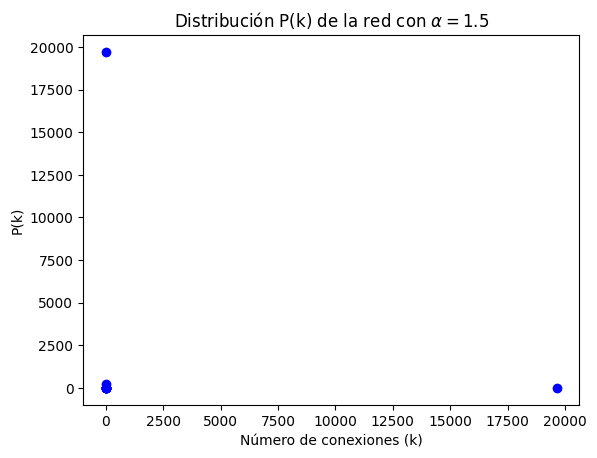

In [184]:
red4 = redBM(20000,1.5)
red4.plotPK()